# Caltech UCSD Birds 200 2011 (CUB-200-2011)

## Part 4 - Evaluating a PyTorch ResNet152 convolutional neural network (CNN) using a held out validation image set.

This notebook shows how to assess the performance of a ResNet152 CNN model using the CUB-200-2011 database of birds. Given a set of held-out test images from the 200 classes of birds, we will use the images to perform prediction, that is, show the network each image and get it to produce a prediction of class. As we have the true class labels, we can perform a number of evaluation techniques comparing the predicted labels to the true labels, to get an idea of how our model performs with this fine-grained image classification problem. We will see how to load a model, and pass both single images and test datasets for prediction.

The previous notebooks showed how to train a ResNet 152 model which had been initialised with pre-trained weights from ImageNet, for the task of fine grained image classification of bird species using the CUB-200-2011 dataset.

This notebook is now going to show: 

    1. How to set up a dataloader for use as a test image set loader.
    
    2. How to load a trained ResNet152 model on the CUB-200-2011 dataset, and setup ready for performing inference (prediction).
    
    3. How to perform model inference using a held out test image set to create a vector of predicted class labels and/or class probabilities.
    
        a. On a single image.
        
        b. On a test image set.
    
    4. How to evaluate the predictions from a neural network using the following approaches:
    
        a. Metrics and classification report.
        
        b. Confusion matrix.
        
        c. ROC and Precision / Recall Curves
    
    5. Misclassification investigations using class probabilities.

## Notebook setup

### Modules and externals

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model, visualize_model_grid
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms
from cub_tools.evaluation import make_predictions_proba

### Runtime setup

In [2]:
# Script runtime options
model = 'resnet152'
data_root_dir = '../data'
model_root_dir = '../models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

## Dataloaders

As before, we setup the dataloaders and transformations for feeding into the neural network.

In this example, we only need to load the test image dataset, as we are loading the pre-trained model from the previous network.

In [3]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [4]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

## Device setup and model load

We now need to specify the device, again this time we will be using a GPU if available, CPU if not.
Single image inference should be tractable on a CPU, however full test set evaluation will need a GPU.

Following the device setup, we then load the CUB-200-2011 trained ResNet152 model.

In [5]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [6]:
# Load the best model from file
model_ = torch.load(model_file)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by acc

## Single image predictions

In this section, we provide a function with the model, class names, the device to run the prediction on (in this case a GPU), and the test set data loader

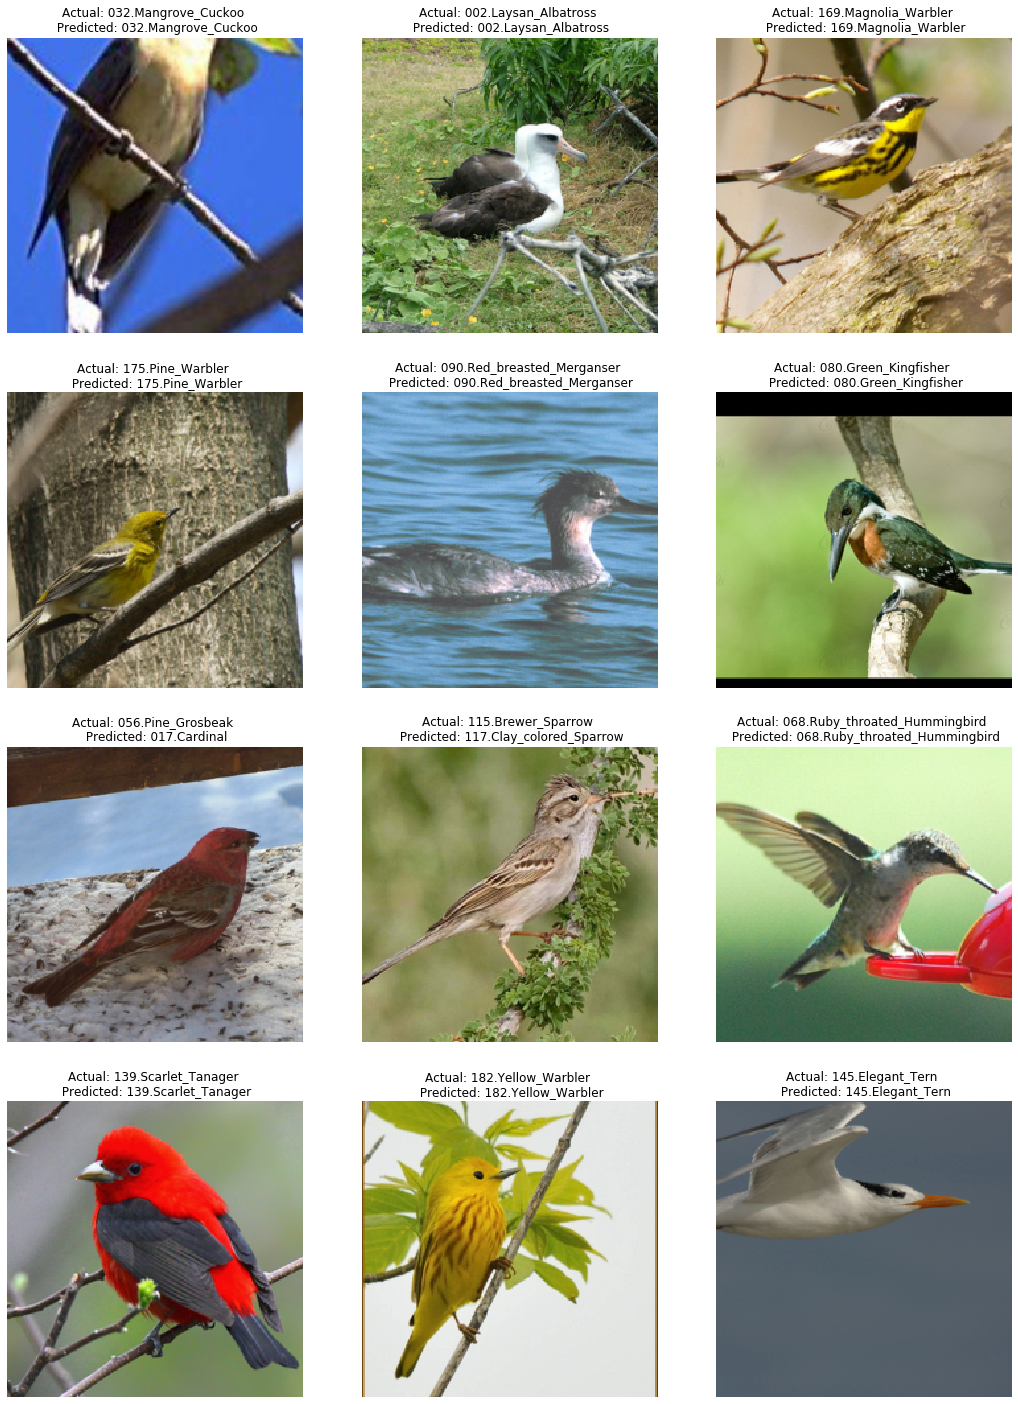

In [10]:
visualize_model_grid(model=model_, class_names=class_names, device=device, dataloaders=dataloaders, num_images=12, figsize=(18,25))

## Evaluation over the whole test set

Now we are going to perform an evaluation on all ~6000 images of the test set to get a really good idea at how our network is performing.

The function below returns 3 objects in a python dictionary.

1. True labels vector.

    n x 1 vector of integers from 1 to 200 indicating true class label for the image.

2. Predicted labels vector.

    n x 1 vector of integers from 1 to 200 indicating the predicted label for the image.

3. Scores matrix.

    n x c matrix of probabilities in the range of 0 to 1.0, where c is the number of classes.

In [13]:
results_dict = make_predictions_proba(model=model_, dataloaders=dataloaders, device=device)

Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..Complete.


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [17]:
print(classification_report(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred'], target_names=class_names))

                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.71      0.83      0.77        30
              002.Laysan_Albatross       0.93      0.83      0.88        30
               003.Sooty_Albatross       0.75      0.86      0.80        28
             004.Groove_billed_Ani       0.90      0.93      0.92        30
                005.Crested_Auklet       0.87      0.93      0.90        14
                  006.Least_Auklet       0.82      0.82      0.82        11
               007.Parakeet_Auklet       0.92      0.96      0.94        23
             008.Rhinoceros_Auklet       0.80      0.89      0.84        18
              009.Brewer_Blackbird       0.52      0.41      0.46        29
          010.Red_winged_Blackbird       0.96      0.90      0.93        30
               011.Rusty_Blackbird       0.69      0.67      0.68        30
       012.Yellow_headed_Blackbird       0.93      0.96      0.94        26
           

In [18]:
class_report_df = pd.DataFrame(classification_report(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred'], target_names=class_names, output_dict=True))
class_report_df

001.Black_footed_Albatross  002.Laysan_Albatross  \
precision                    0.714286              0.925926   
recall                       0.833333              0.833333   
f1-score                     0.769231              0.877193   
support                     30.000000             30.000000   

           003.Sooty_Albatross  004.Groove_billed_Ani  005.Crested_Auklet  \
precision             0.750000               0.903226            0.866667   
recall                0.857143               0.933333            0.928571   
f1-score              0.800000               0.918033            0.896552   
support              28.000000              30.000000           14.000000   

           006.Least_Auklet  007.Parakeet_Auklet  008.Rhinoceros_Auklet  \
precision          0.818182             0.916667               0.800000   
recall             0.818182             0.956522               0.888889   
f1-score           0.818182             0.936170               0.842105   
support           11.000000            23.000000              18.000000   

           009.Brewer_Blackbird  010.Red_winged_Blackbird  ...  \
precision              0.521739                  0.964286  ...   
recall                 0.413793                  0.900000  ...   
f1-score               0.461538                  0.931034  ...   
support               29.000000                 30.000000  ...   

           194.Cactus_Wren  195.Carolina_Wren  196.House_Wren  197.Marsh_Wren  \
precision         0.964286           0.818182        0.733333        0.785714   
recall            0.900000           0.900000        0.733333        0.733333   
f1-score          0.931034           0.857143        0.733333        0.758621   
support          30.000000          30.000000       30.000000       30.000000   

           198.Rock_Wren  199.Winter_Wren  200.Common_Yellowthroat  accuracy  \
precision       0.896552         0.806452                 0.966667  0.821194   
recall          0.866667         0.833333                 0.966667  0.821194   
f1-score        0.881356         0.819672                 0.966667  0.821194   
support        30.000000        30.000000                30.000000  0.821194   

             macro avg  weighted avg  
precision     0.824722      0.824807  
recall        0.822210      0.821194  
f1-score      0.819541      0.819001  
support    5794.000000   5794.000000  

[4 rows x 203 columns]

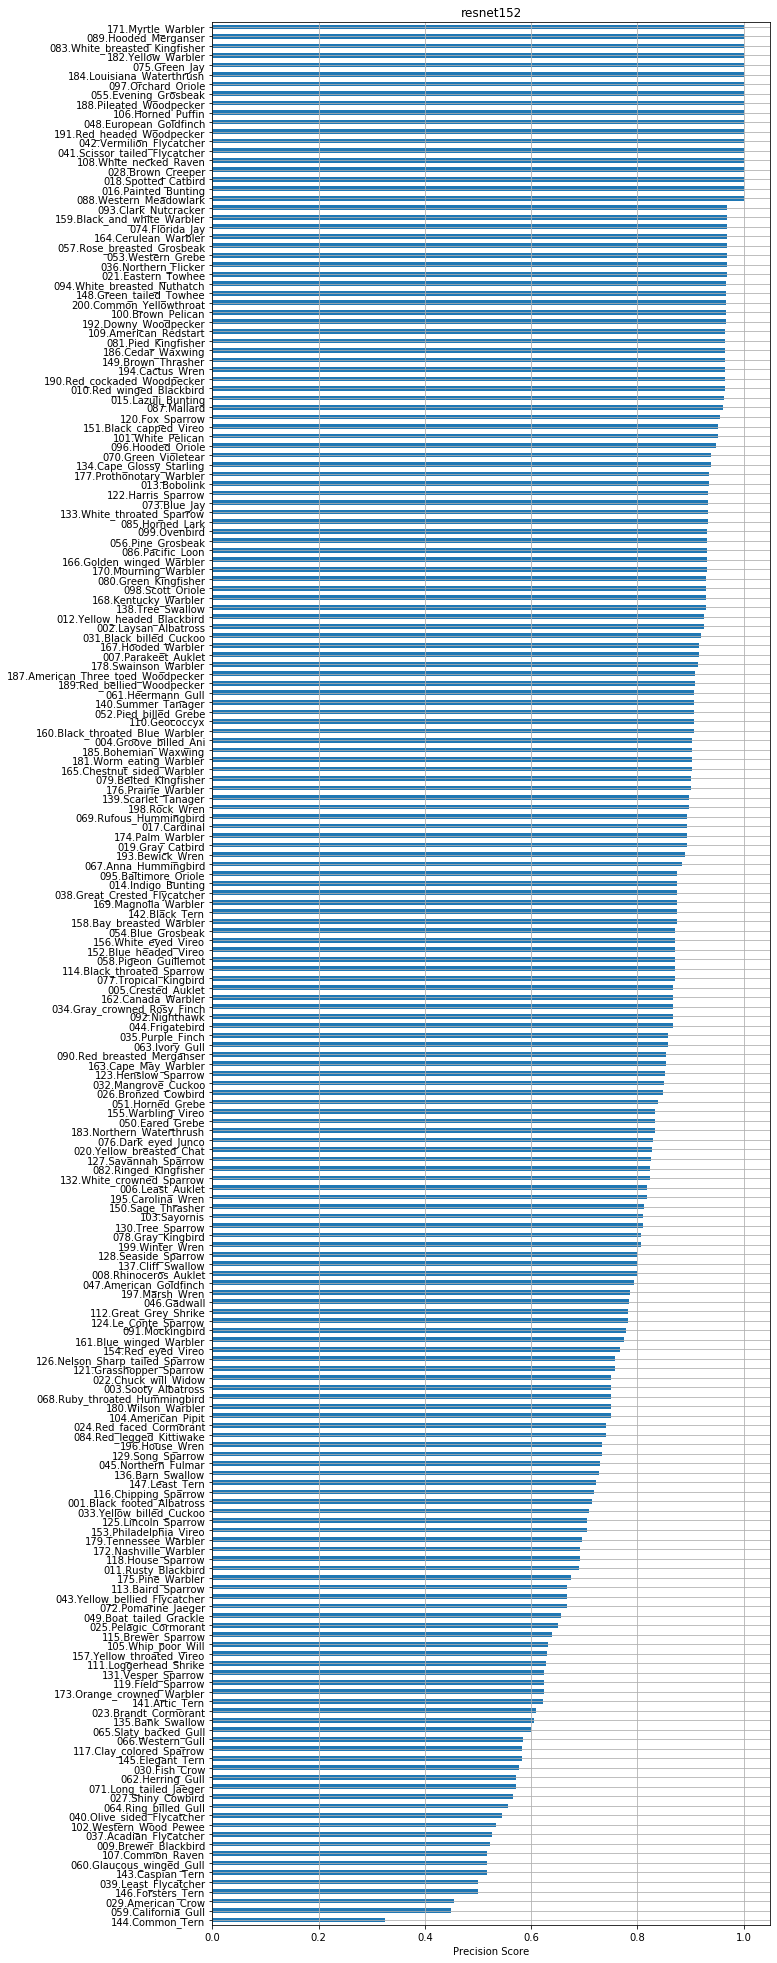

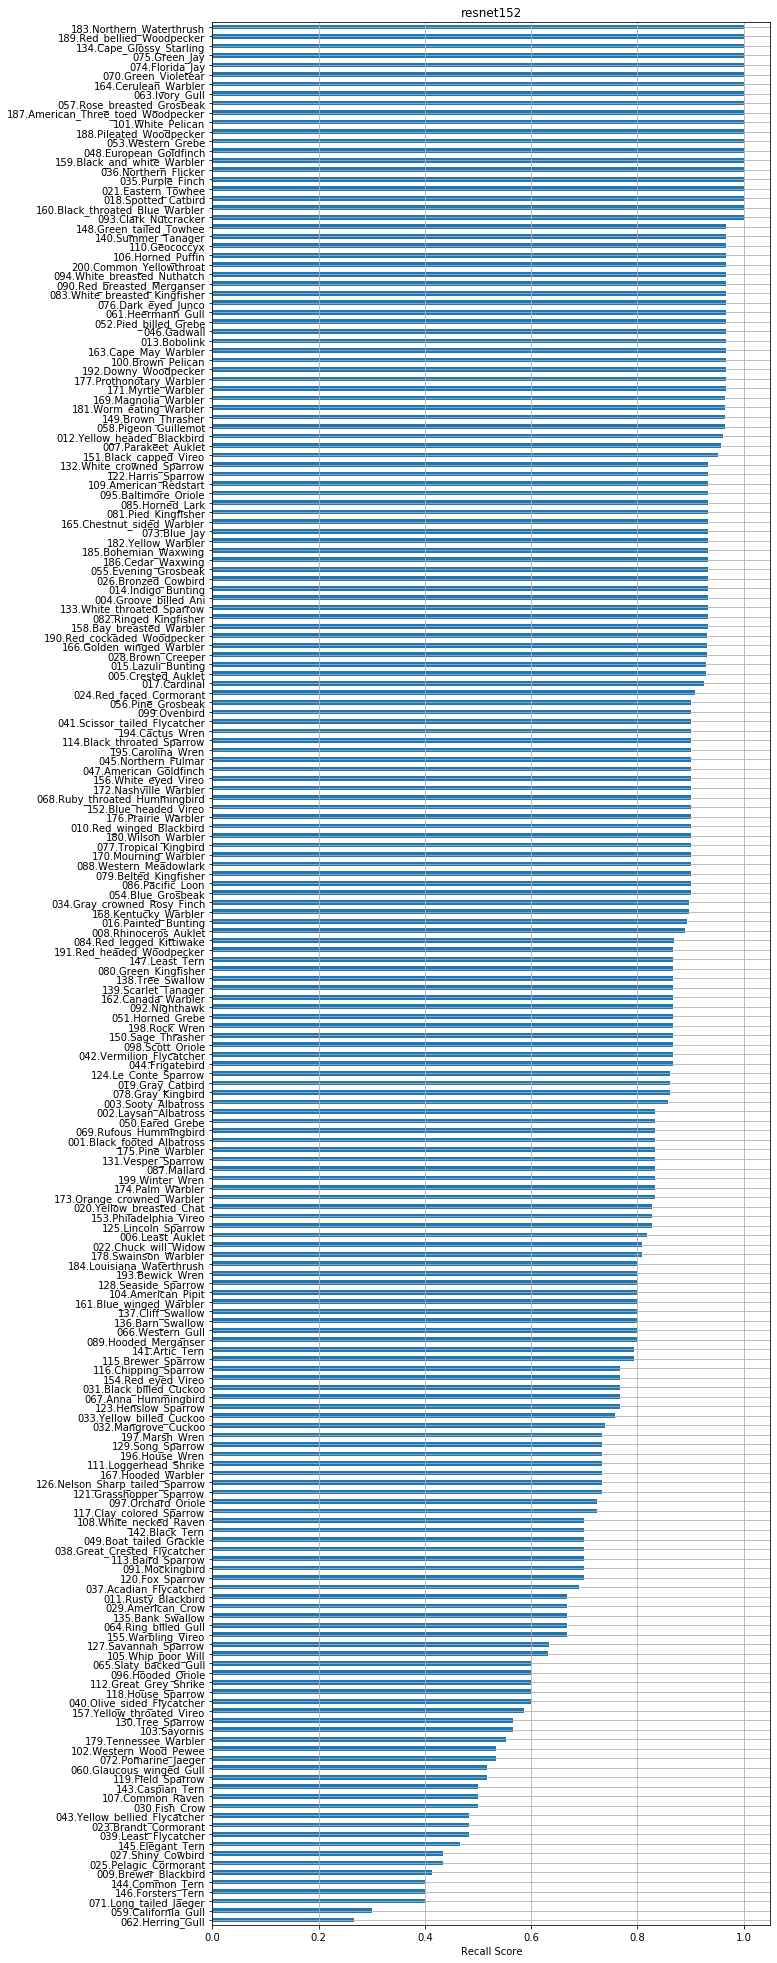

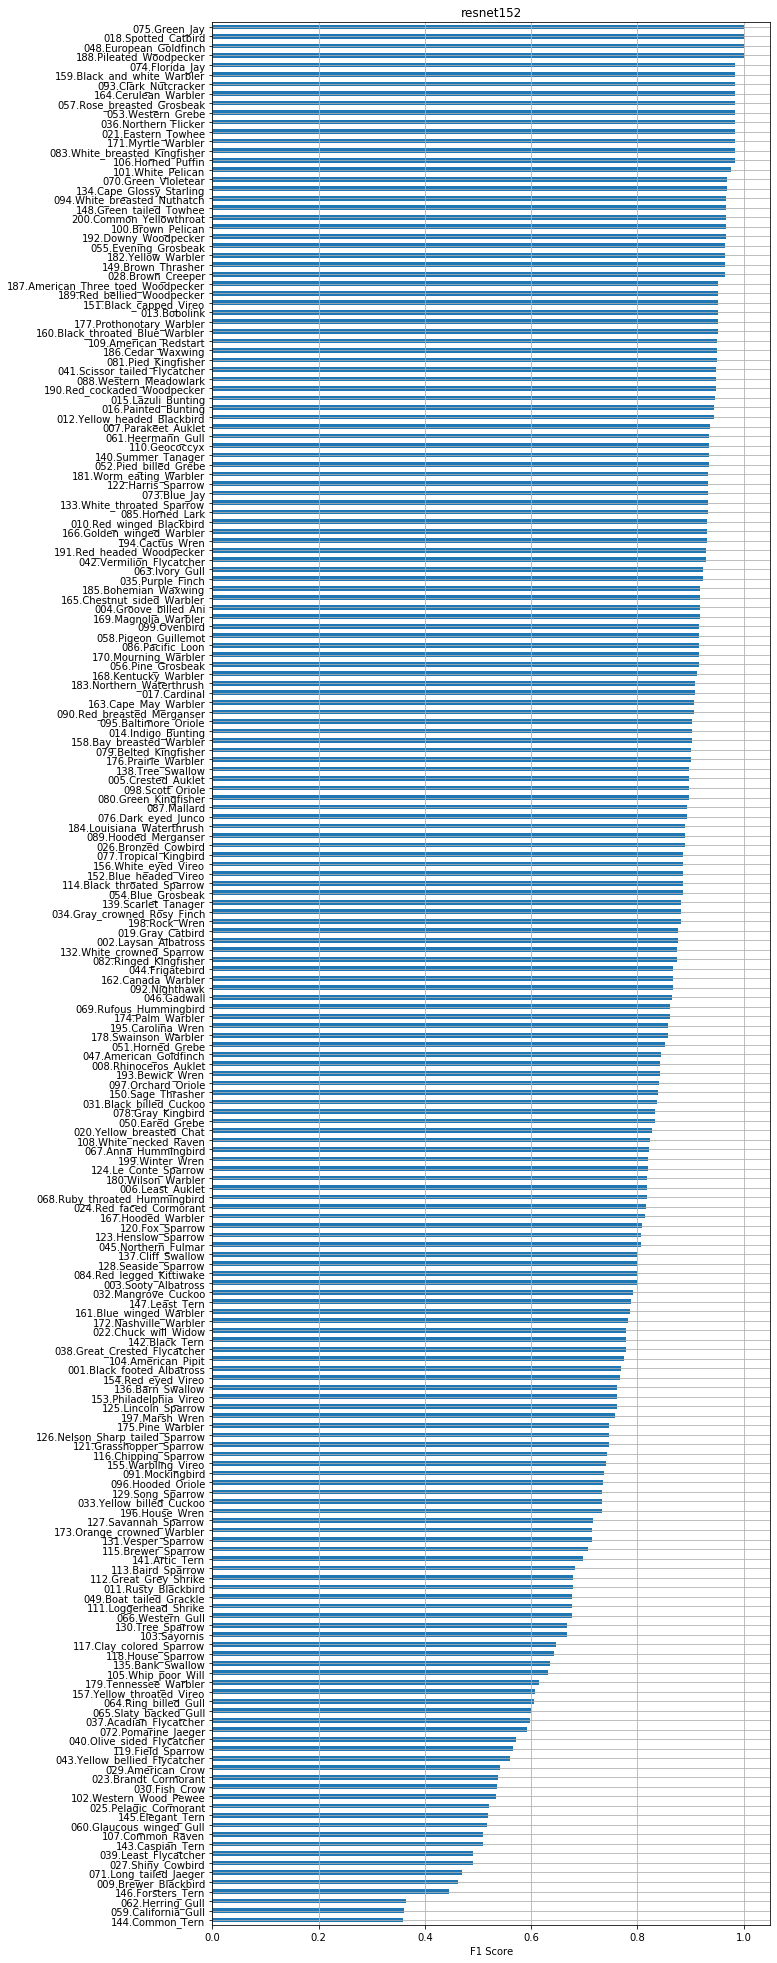

In [19]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [21]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=results_dict['labels truth'], y_pred=results_dict['labels pred']), index=class_names, columns=class_names)

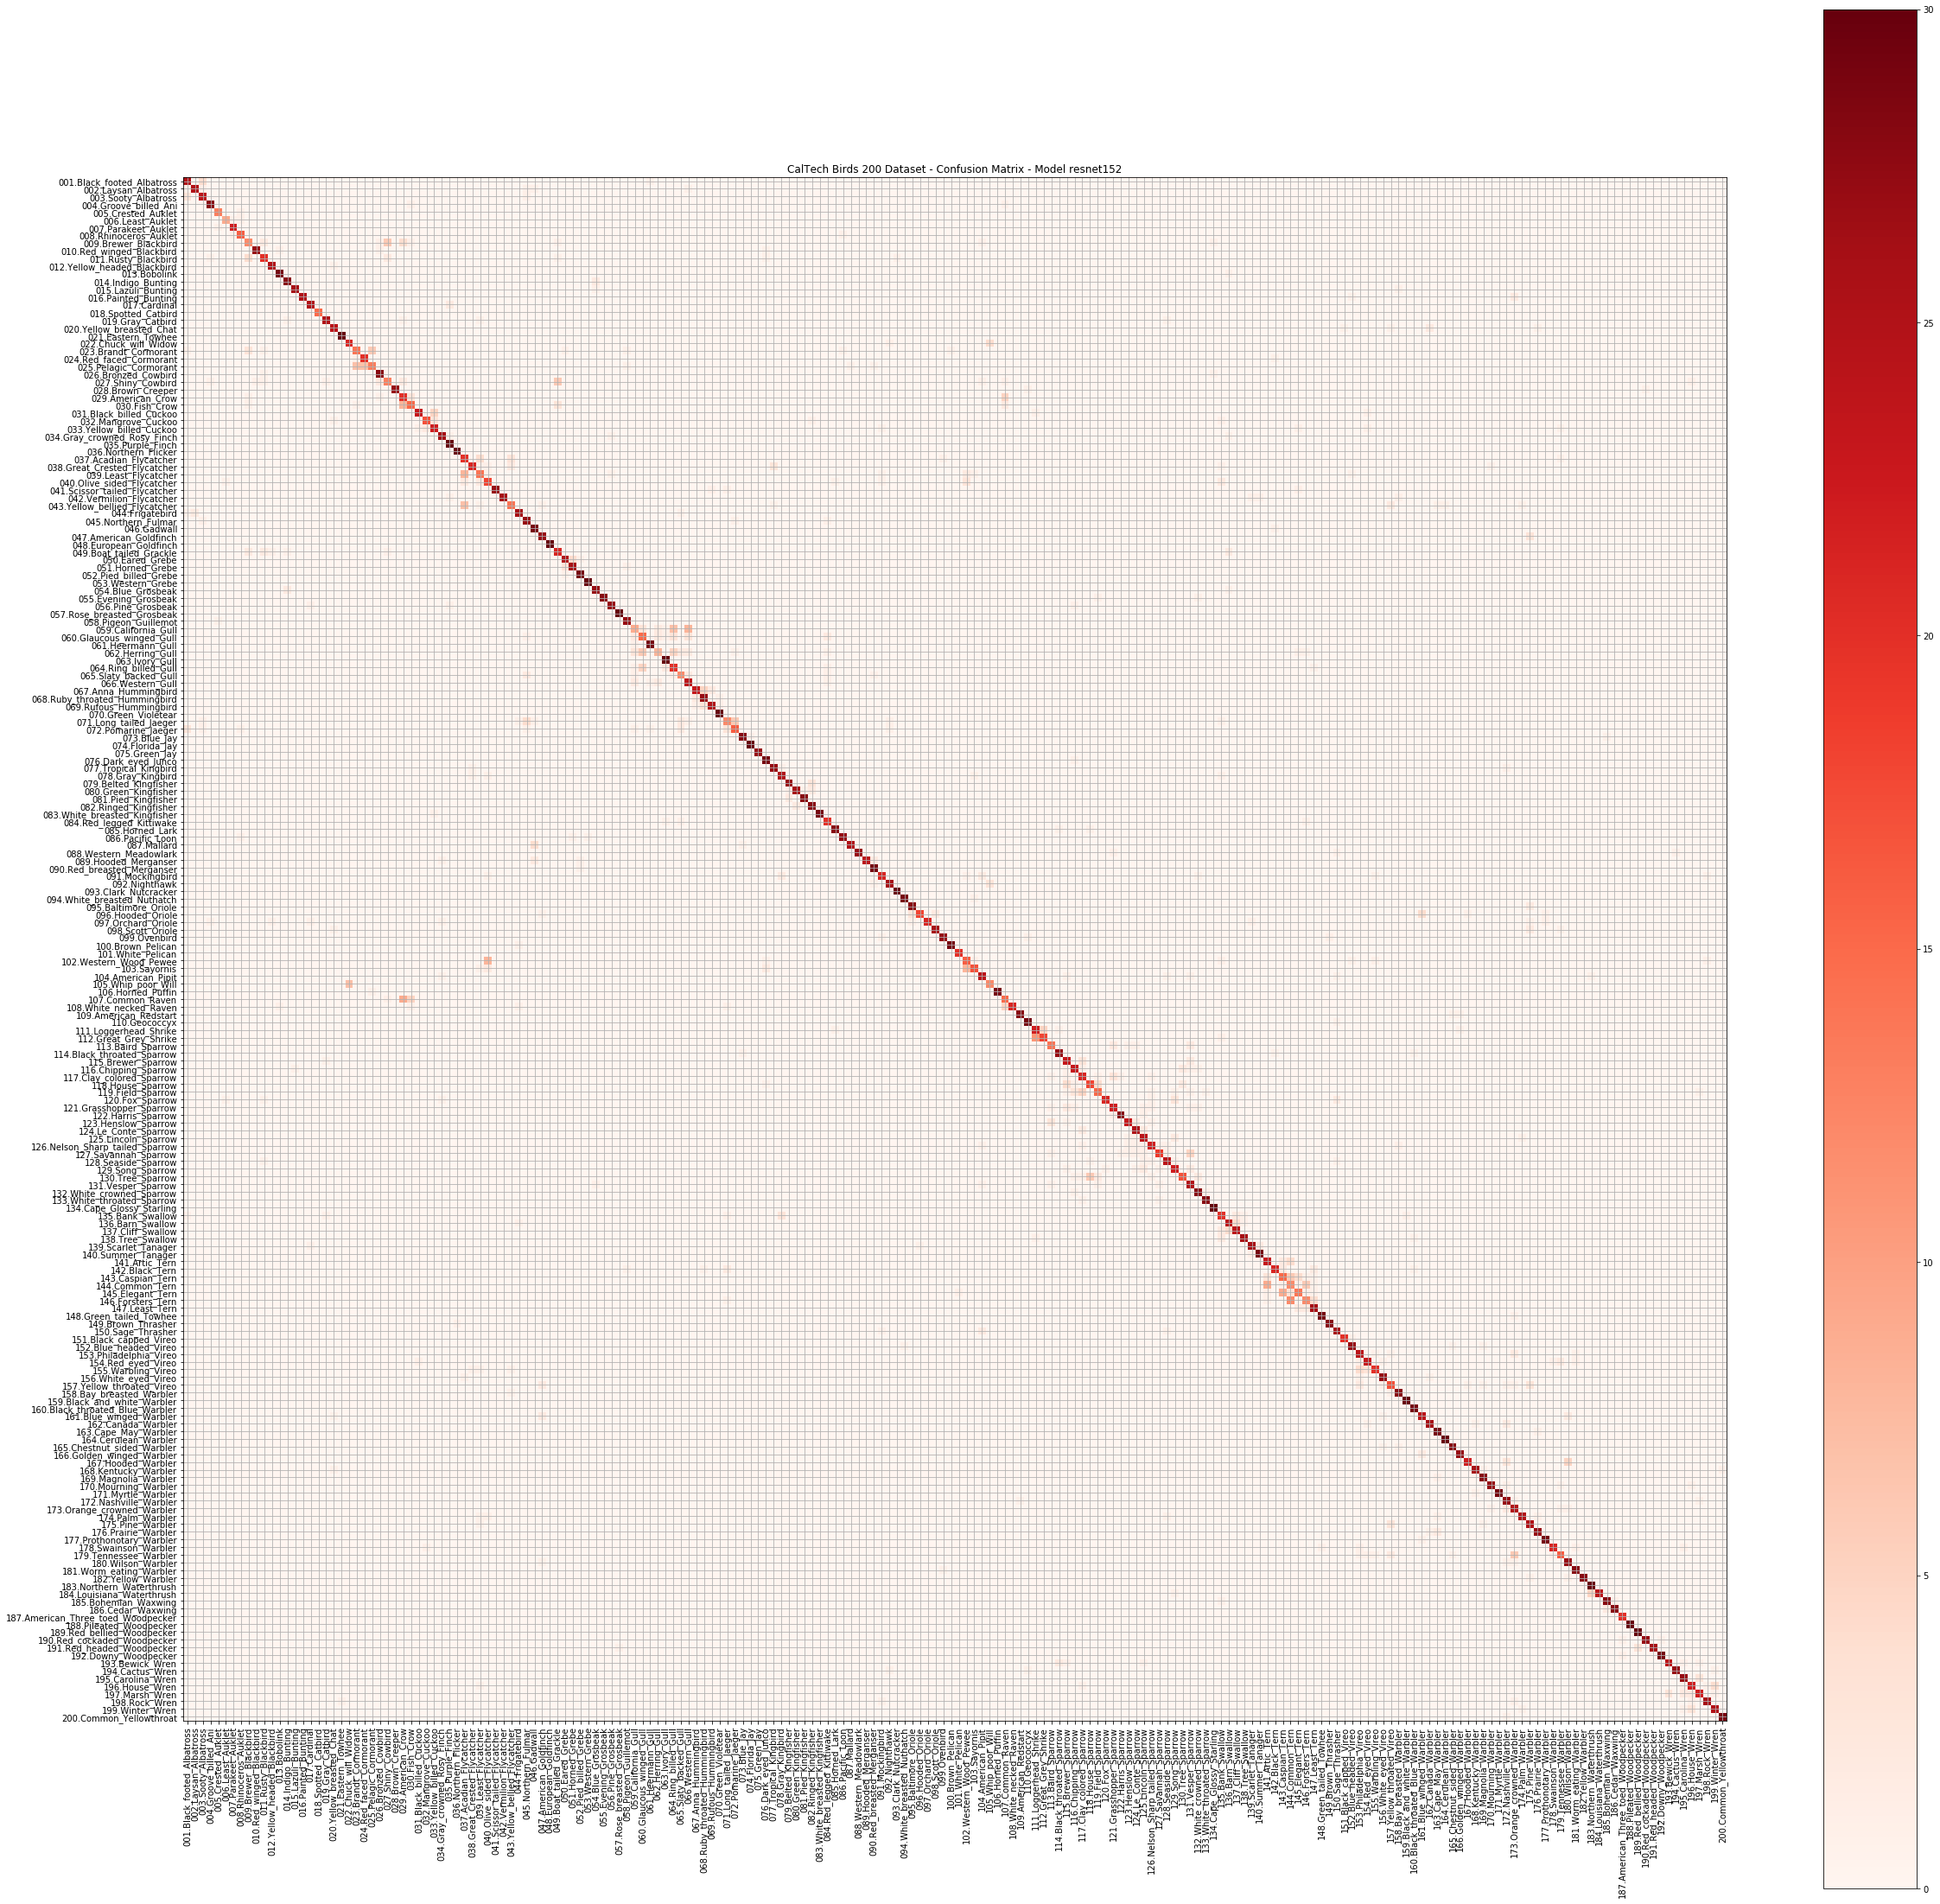

In [22]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [ ]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
save_pickle(pkl_object=results_dict, fname=os.path.join(output_dir,'model_results.pkl'))

In [34]:
from scikitplot.metrics import plot_roc, plot_precision_recall

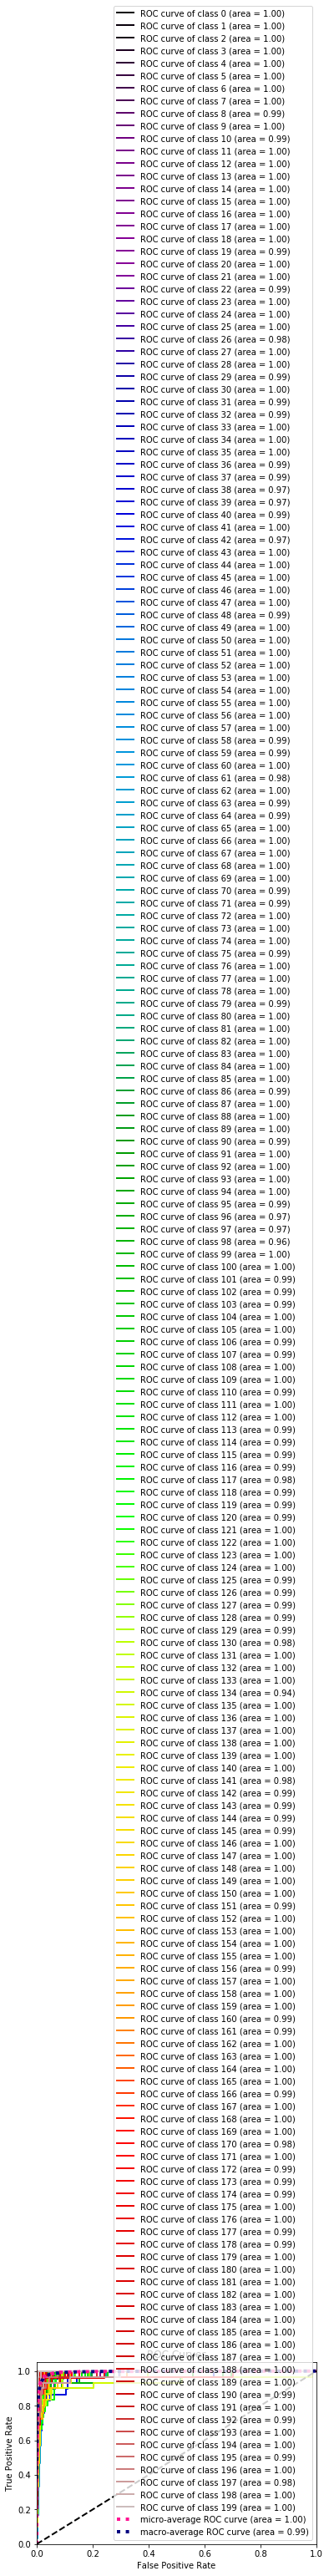

In [35]:
plot_roc(y_true=results_dict['labels truth'], y_probas=results_dict['scores pred'])

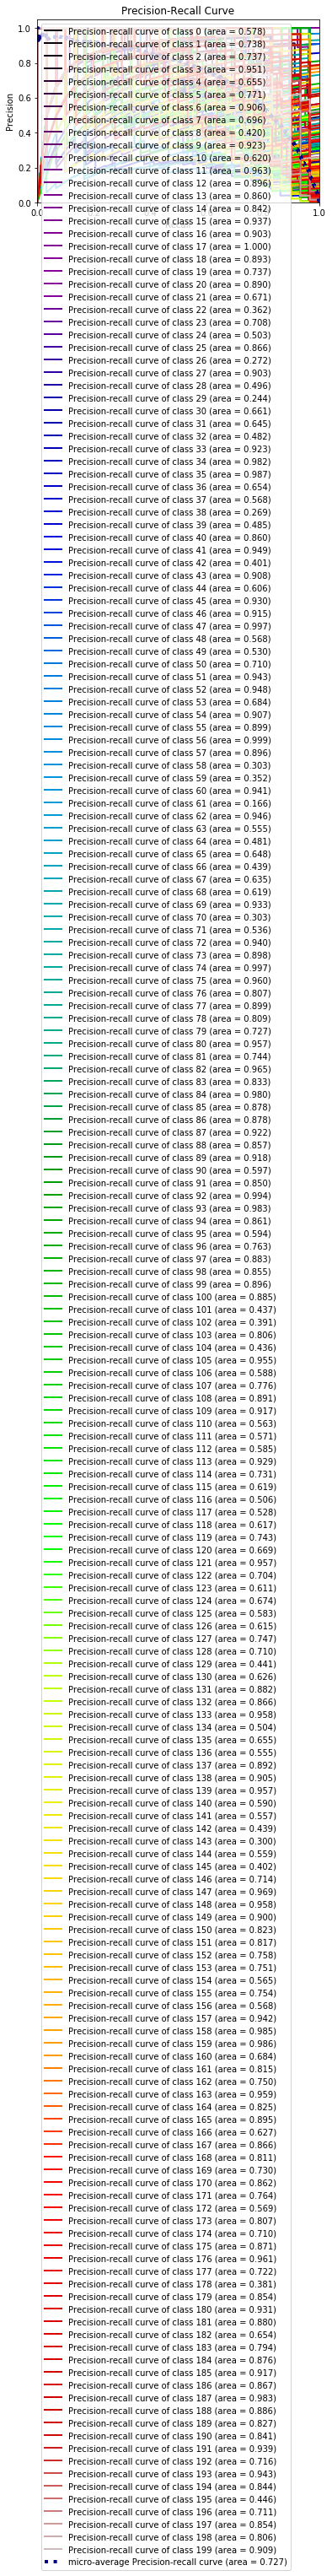

In [36]:
plot_precision_recall(y_true=results_dict['labels truth'], y_probas=results_dict['scores pred'])

In [23]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [24]:
results_dict.keys()

dict_keys(['labels truth', 'labels pred', 'scores pred'])

In [25]:
results_dict['scores pred'].shape

(5794, 200)

In [26]:
misclass_scores = []
for i in range(results_dict['scores pred'].shape[0]):
    if results_dict['labels truth'][i] != results_dict['labels pred'][i]:
        misclass_scores.append( 
            {
                'label truth' : results_dict['labels truth'][i],
                'label pred' : results_dict['labels pred'][i],
                'scores' : softmax(results_dict['scores pred'][i,:])
            }
        )

In [27]:
pd.DataFrame(misclass_scores)

label truth  label pred  \
0              94         174   
1             134          77   
2             129         117   
3              38          36   
4             114         116   
...           ...         ...   
1031           40         144   
1032           67          66   
1033           70          44   
1034           61         145   
1035           48          13   

                                                 scores  
0     [6.2181675e-06, 1.0092221e-05, 7.0740725e-06, ...  
1     [1.1242118e-07, 1.7686796e-06, 6.885248e-07, 5...  
2     [2.659546e-06, 7.937528e-06, 3.2457806e-06, 3....  
3     [3.7623602e-07, 2.6567312e-07, 1.2441659e-06, ...  
4     [1.5725516e-07, 3.670869e-07, 9.935794e-08, 1....  
...                                                 ...  
1031  [0.00019725822, 0.0012392909, 0.0026904084, 3....  
1032  [2.2689942e-06, 1.3715834e-06, 1.6609385e-05, ...  
1033  [0.0013214468, 0.00010164239, 0.00089720427, 7...  
1034  [1.9019943e-05, 0.0002703583, 0.00018264646, 6...  
1035  [4.0939594e-06, 3.6224787e-06, 6.302859e-06, 0...  

[1036 rows x 3 columns]

In [28]:
misclass_scores_array = []
for m in misclass_scores:
    misclass_scores_array.append( m['scores'] )
misclass_scores_array = np.asarray(misclass_scores_array)

In [29]:
misclass_scores_array.shape

(1036, 200)

In [31]:
test_img_i = 5

results = softmax(results_dict['scores pred'][test_img_i])

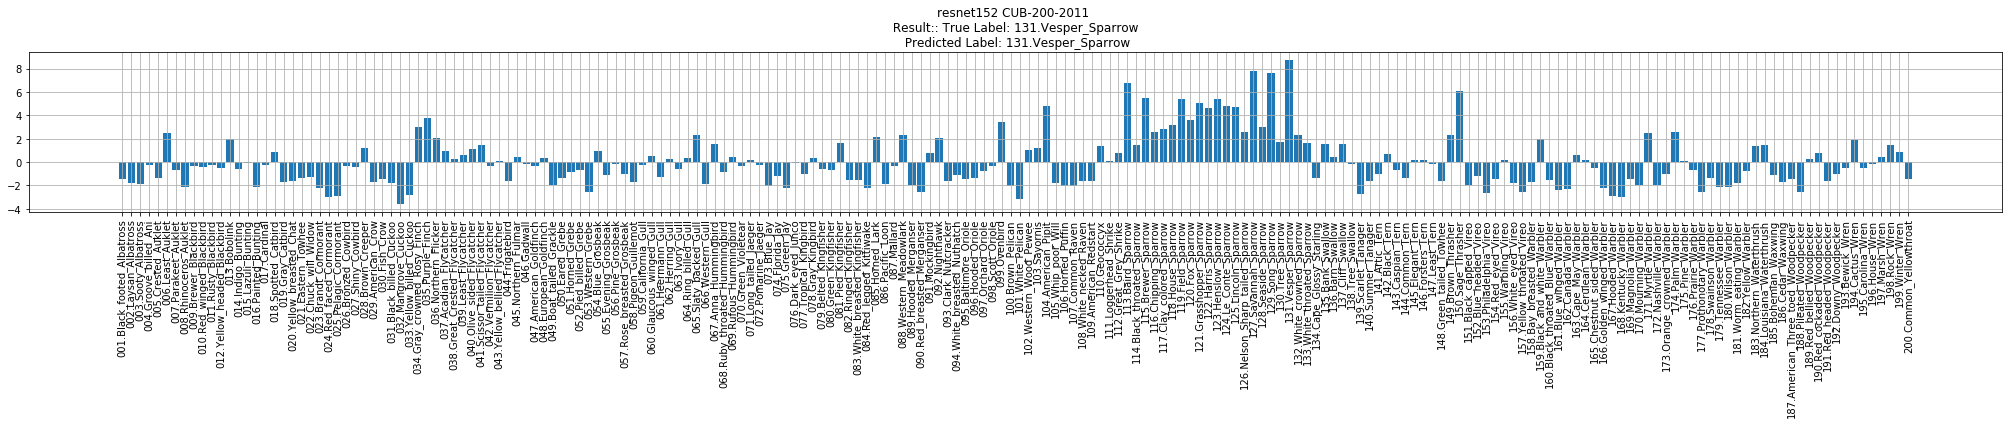

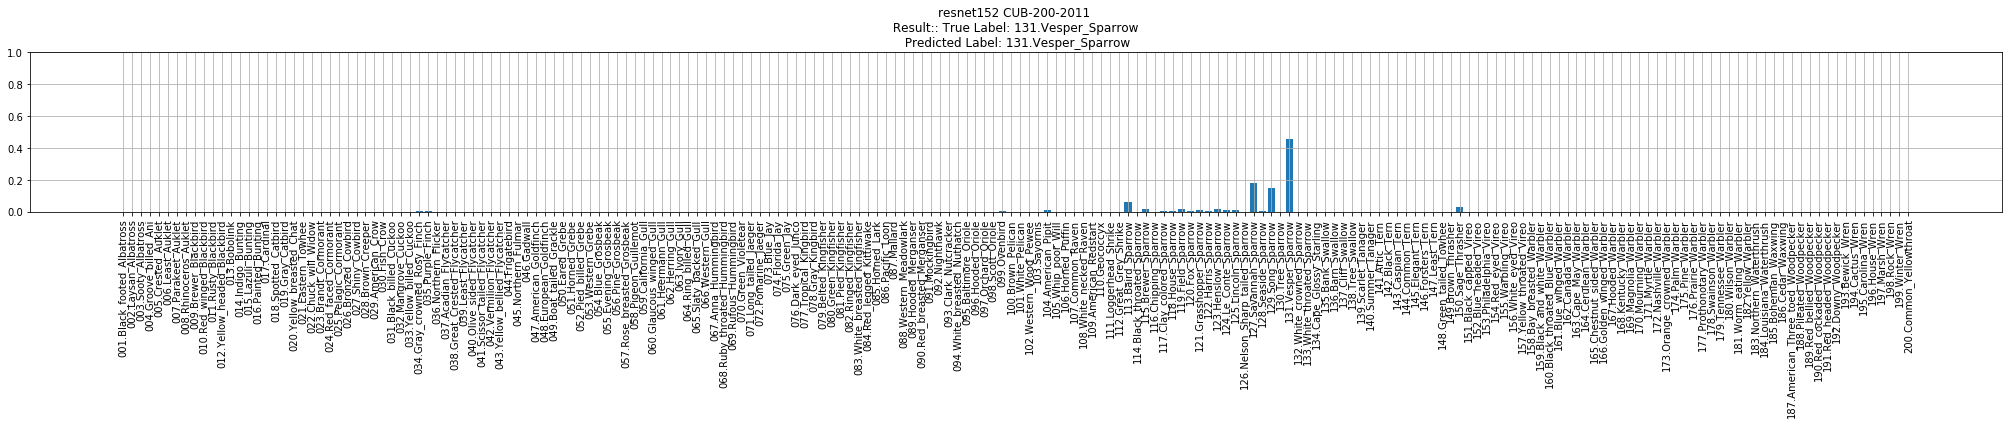

In [32]:
plt.figure(figsize=(28,6))
plt.bar(class_names,height=results_dict['scores pred'][test_img_i])
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(28,6))
plt.bar(class_names,height=results)
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.ylim([0.0, 1.0])
plt.show()